# Logistic Regression in Python
We are going to apply logistic regression using **sklearn**, covering:
* How to explore, clean and transform the data
* how to split into training and test datasets
* How to fit, evaluate, and interpret the model.

### STEP 1: Impot Python Libraries


In [1]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

### STEP 2: Explore and Clean Data

We will be using the *Heart Attack directory from Kaggle*. The goal is to predict the binary target, whether the patient has heart disease or not.
<br>
<br>
Upon downloading the csv file, we can use **read_csv** to load the data as a pandas DataFrame. We are also going to specify ```na_value='?'``` since they represent missing values in the dataset.

In [3]:
# https://www.kaggle.com/imnikhilanand/heart-attack-prediction/data?select=data.csv 
df = pd.read_csv('data.csv', na_values='?')

In [4]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

This shows that there are 14 variables available for analysis. 'num' is the **target**, a value of 1 shows the presence of heart disease and 0 the opposite. We start by renaming this to 'target' so we aren't getting lost:

In [5]:
df = df.rename(columns={'num       ': 'target'})

df['target'].value_counts(dropna=False)

0    188
1    106
Name: target, dtype: int64

There is only a slight imbalance towards 0, so no adjustments are needed.

In [6]:
# Summary information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


So we see some important information:
* There are 294 observations in the dataset
* There are 13 features aside from 'target'
<br>
To keep the cleaning process simple, remove:
* The columns with many missing values (*slope, ca, thal*)
* The rows with missing values.

In [7]:
df = df.drop(['slope', 'ca', 'thal'], axis=1)

df = df.dropna().copy()

In [8]:
# Re-check summary after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       261 non-null    int64  
 1   sex       261 non-null    int64  
 2   cp        261 non-null    int64  
 3   trestbps  261 non-null    float64
 4   chol      261 non-null    float64
 5   fbs       261 non-null    float64
 6   restecg   261 non-null    float64
 7   thalach   261 non-null    float64
 8   exang     261 non-null    float64
 9   oldpeak   261 non-null    float64
 10  target    261 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 24.5 KB


Now, we see our ten features that will be used in the analysis. Some feature labels aren't very intuitive, so here is a breakdown:
* cp: Chest pain type
    * 1 - typical angina
    * 2 - atypical angina
    * 3 - non-anginal pain
    * 4 - asymptomatic
* trestbps: resting blood pressure (in mm/Hg on hospital admission)
* chol: serum cholesterol (mg/dl)
* fbs: (fasting blood sugar > 120mg/dl)(1 = true; 0 = false)
* restecg: resting electrocardiographic results
    * 0 - normal
    * 1 - having ST-T wave abnormality
    * 2 - showing probable or definite left ventricular hypertrophy
* thalach: maximum heart rate achieved
* exang: exercise-induced angina (1 = yes; 2 = no)
* oldpeak: ST depression induced by exercise relative to rest


In [10]:
# We can also check out the dataframe
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,0
5,32,0,2,105.0,198.0,0.0,0.0,165.0,0.0,0.0,0


As seen, we have exactly 5 categorical variables and 5 numerical variables. 

### STEP 3: Transform the Categorical Variables using Dummy Variables

When fitting log regression, we often will turn categorical variables into dummies. Of the 5 cat variables; sex, fbs and exang only have two levels (0 and 1), so they are already in a *dummy format*. We still need to convert cp and restecg.
<br>
<br>
We still should check out these variables first:

In [12]:
df['cp'].value_counts(dropna=False)

4    113
2     92
3     46
1     10
Name: cp, dtype: int64

In [13]:
df['restecg'].value_counts(dropna=False)

0.0    208
1.0     47
2.0      6
Name: restecg, dtype: int64

There are 4 classes for cp and three for restecg. 
We can use the get_dummies function to convert them into dummy variables. The drop_first parameter is set to True so that the unnecessary first level dummy variable is removed.

In [14]:
df = pd.get_dummies(df, columns=['cp', 'restecg'], drop_first=True)

df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_2,cp_3,cp_4,restecg_1.0,restecg_2.0
0,28,1,130.0,132.0,0.0,185.0,0.0,0.0,0,1,0,0,0,1
1,29,1,120.0,243.0,0.0,160.0,0.0,0.0,0,1,0,0,0,0
3,30,0,170.0,237.0,0.0,170.0,0.0,0.0,0,0,0,0,1,0
4,31,0,100.0,219.0,0.0,150.0,0.0,0.0,0,1,0,0,1,0
5,32,0,105.0,198.0,0.0,165.0,0.0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,160.0,331.0,0.0,94.0,1.0,2.5,1,0,0,1,0,0
290,54,0,130.0,294.0,0.0,100.0,1.0,0.0,1,0,1,0,1,0
291,56,1,155.0,342.0,1.0,150.0,1.0,3.0,1,0,0,1,0,0
292,58,0,180.0,393.0,0.0,110.0,1.0,1.0,1,1,0,0,0,0


In [15]:
#before moving on: 
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = list(set(df.columns) - set(numeric_cols) - {'target'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
['cp_2', 'cp_3', 'cp_4', 'exang', 'fbs', 'restecg_1.0', 'restecg_2.0', 'sex']


We now have our numerical columns and categorical dummies

### STEP 4: Split Training and Test Datasets
To make sure our fitted model can generalize unseen data, we always will train it using some data while evaluating that model with holdout data. We need to split the original dataset into training and test sets.
<br>
<br>
We will be using train_test_split with these specs:
* test_size = 0.2: keep 20% of the original dataset as the test dataset, i.e., 80% as the training dataset.
* stratify=df[‘target’]: when the dataset is imbalanced, it’s good practice to do stratified sampling. In this way, both the training and test datasets will have similar portions of the target classes as the complete dataset.
<br>
<br>
To verify the specifications, we can print out the shapes and classes of target for both training and test sets.

In [16]:
# conduct train_test_split
random_seed = 888 # Seed is needed to replicate same results every runtime
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['target'])


print(df_train.shape)
print(df_test.shape)
print()
print(df_train['target'].value_counts(normalize=True))
print()
print(df_test['target'].value_counts(normalize=True))

(208, 14)
(53, 14)

0    0.625
1    0.375
Name: target, dtype: float64

0    0.622642
1    0.377358
Name: target, dtype: float64


### STEP 5: Transform the Numerical Variables: Scaling
Before fitting the model, let's also scale the numerical values, which is another common practice in machine learning.
<br>
After creating a class of **StandardScaler**, we calculate (or *fit*) the mean and standard deviation for scaling using df_train's numeric_cols. Then we create a function *get_features_and_target_arrays*:
* performs standardization on the numeric columns of DataFrame to return the new array *X_numeric_scaled*
* Transforms categorical columns to a NumPy array *X_categorical*
* combines both arrays back to the entire feature array *X*
* assigns the target column to *y*.

We can then apply this function to our training dataset to output our training feature and target; X and y.
<br>
<br>*NOTE: This has to be done AFTER train_test_split*

In [17]:
# Create our scaler and fit our training data
scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

#Define function
def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['target']
    return X, y

X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

### STEP 6: Fit the Logistic Regression Model
Finally, we can fit the logistic regression in Python on our example dataset.
<br>
<br> We first create an instance *clf* of the class LogisticRegression. We can fit it using the training data

In [19]:
clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.

clf.fit(X, y)

LogisticRegression(penalty='none')

### STEP 7: Evaluate the Model
After fitting the model to our logistic regression, let's look at some popular evaluation metrics for the dataset. We first have to scale the test dataset:

In [20]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

We can then plot our ROC curve

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


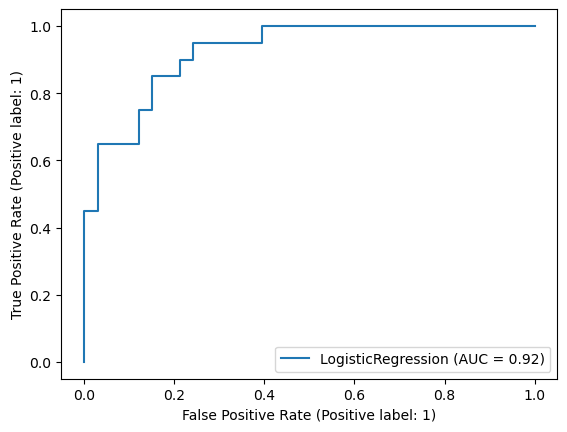

In [21]:
plot_roc_curve(clf, X_test, y_test)

And, the precision-recall curve

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


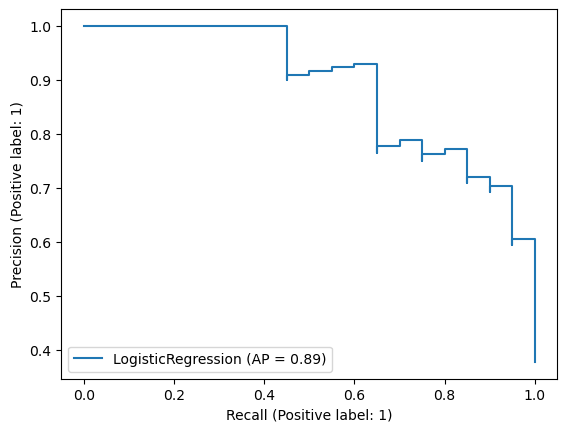

In [22]:
plot_precision_recall_curve(clf, X_test, y_test)

To calculate other metrics, we need to get the prediction results from our test dataset:
* **predict_proba** to get the predicted probability of the Logistic Regression for each class in our model. The first column of this metrics output is *P*(target = 0), and the second column is *P*(target = 1). So we are calling for the second column by its index position of 1.
* **predict** the test dataset labels by choosing the class with the highest probability, which means a threshold of 0.5 in this binary example.

In [23]:
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

Using the below Python code, we can calculate some other evaluation metrics:
<br>
* Log loss
* AUC
* Average Precision
* Accuracy
* Precision
* Recall
* F1 score
* Classification report, which contains some of the above plus extra information
<br>
More details can be found in the scikit-learn [documentation](https://scikit-learn.org/stable/modules/model_evaluation)

In [24]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.35613
AUC = 0.92424
Average Precision = 0.89045

Using 0.5 as threshold:
Accuracy = 0.83019
Precision = 0.76190
Recall = 0.80000
F1 score = 0.78049

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.76      0.80      0.78        20

    accuracy                           0.83        53
   macro avg       0.82      0.82      0.82        53
weighted avg       0.83      0.83      0.83        53



It's also a good idea to get the metrics for our training set to be able to cross-compare. If the training set gives higher accuracy, for example, there could be overfitting.
<br>
To show the **confusion matrix**, we can plot a heatmap, which is also based on a threshold of 0.5 for binary classification.

Confusion Matrix


/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


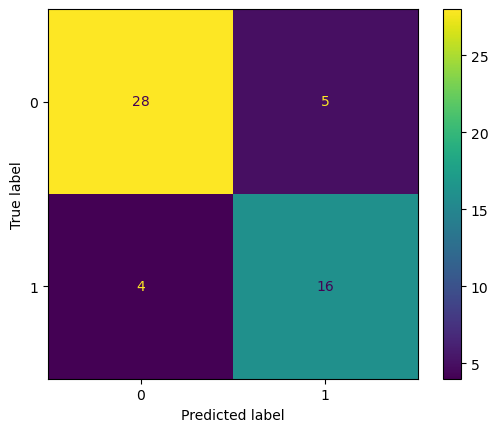

In [25]:
print('Confusion Matrix')
plot_confusion_matrix(clf, X_test, y_test)

### STEP 8: Interpret the results
In our last step, we will interpret the results of our example logistic regression model. We'll cover both the categorical feature and the numerical feature.

In [27]:
# Stack our coefficient arrays in sequence, horizontally
# note: arrays must have same shape
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))

# Set the data in a dataframe
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})


,variable,coefficient
0,intercept,-0.178340
1,cp_2,-2.895253
2,cp_3,-1.808676
3,cp_4,-0.830942
4,exang,0.514580
5,fbs,1.514143
6,restecg_1.0,-0.638990
7,restecg_2.0,-0.429625
8,sex,1.290292
9,age,0.059633


For categorical feature sex, this fitted model says that holding all the other features at fixed values, the odds of having heart disease for males (sex=1) to the odds of having heart disease for females is exp(1.290292). You can derive it based on the logistic regression equation.
<br>
<br>
For categorical feature cp (chest pain type), we have created dummy variables for it, the reference value is typical angina (cp = 1). So the odds ratio of atypical angina (cp = 2) to typical angina (cp = 1) is exp(-2.895253).
<br>
<br>
Since the numerical variables are scaled by StandardScaler, we need to think of them in terms of standard deviations. Let’s first print out the list of numeric variable and its sample standard deviation.

In [29]:
pd.DataFrame(data={'variable': numeric_cols, 'unit': np.sqrt(scaler.var_)})

,variable,unit
0,age,7.909365
1,trestbps,18.039942
2,chol,63.470764
3,thalach,24.071915
4,oldpeak,0.891801


For example, holding other variables fixed, there is a 41% increase in the odds of having a heart disease for every standard deviation increase in cholesterol (63.470764) since exp(0.345501) = 1.41.